<a href="https://www.kaggle.com/code/leekahwin/visualize-forecast-air-pollution-using-arima?scriptVersionId=103927600" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

* [Import Packages and Read Data](#0.1)
* [Define Visualisation Functions](#0.2)
* [Plot Time Series](#0.3)
* [Plot Forecast Values using ARIMA](#0.4)

# Import Packages and Read Data <a class="anchor" id="0.1"></a>

In [1]:
import pandas as pd
import glob
import os
from tqdm import tqdm
from pandas.api.types import is_numeric_dtype, is_string_dtype

# install forecast tool and pmdarima
!pip install -q forecast-tool
!pip install -q pmdarima
from forecast_tool import forecast_plot as fp

def shape(df,df_name):
    print(f'STATUS: Dimension of "{df_name}" = {df.shape}')
def w(text):
    return print(f'STATUS: {text}')

all_files =[]
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        all_files.append(os.path.join(dirname, filename))

# read all csv

w('Reading all files...')
w('Get all targets ...')
df_list = []
target_list= []
for filename in tqdm(all_files):
    df = pd.read_csv(filename, index_col=None, header=0)
    df = df.drop(['Code','Entity'], axis=1)
    df['Year'] = pd.to_datetime(df['Year'], format='%Y',errors='coerce')
    # remove columns if over 50% is null
    df = df[df.columns[df.isnull().mean() < 0.5]]
    x = df.drop(['Year'], axis=1)
    target_name = x[[x.columns[0]]].columns.values[0]
    df = df[['Year', target_name]].dropna()
    target_list.append(target_name)
    df_list.append(df)
    
w('Get all targets - Done')    
w('Get all files name ...')

# get all files name
titles = []
for mystring in all_files:
    _, _, after_keyword = mystring.partition('/kaggle/input/outdoor-air-pollution/')
    before_keyword, _, _ = after_keyword.partition('.csv')
    titles.append(before_keyword)
w('Get all files name - Done')


w('Get all dates ...')
date_list = []
for df in df_list:
    if 'Year' in df.columns:
        date_list.append('Year')
    else:
        raise Exception('Year not in column')

w('Get all dates - Done')

w('Make sure all targets are numeric ...')
for df, target, date in zip(df_list, target_list,date_list):
    if is_string_dtype(df[target]):
#         df[target] = df[target].str.replace(',', '')
        df[target] = pd.to_numeric(df[target],errors='coerce')
w('Make sure all targets are numeric -Done')  

print(f"STATUS: number of Titles: {len(titles)} == number of FILES: {len(all_files)}\
== number of TARGETS: {len(target_list)} == Date list: {len(date_list)}")


shape_list =[]
for df in df_list:
    shape_list.append(df.shape)
dimension_df = pd.DataFrame({'files':titles,'dimension':shape_list})
dimension_df

STATUS: Reading all files...
STATUS: Get all targets ...


100%|██████████| 16/16 [00:00<00:00, 28.39it/s]

STATUS: Get all targets - Done
STATUS: Get all files name ...
STATUS: Get all files name - Done
STATUS: Get all dates ...
STATUS: Get all dates - Done
STATUS: Make sure all targets are numeric ...
STATUS: Make sure all targets are numeric -Done
STATUS: number of Titles: 16 == number of FILES: 16== number of TARGETS: 16 == Date list: 16


,files,dimension
0,death-rate-from-pm25-vs-pm25-concentration,"(50470, 2)"
1,outdoor-pollution-deaths-1990-2017,"(6840, 2)"
2,emissions-of-air-pollutants,"(78, 2)"
3,ambient-pollution-death-rates-2017-1990,"(50470, 2)"
4,outdoor-pollution-rates-by-age,"(6840, 2)"
5,pm-exposure-1990-2017,"(2508, 2)"
6,share-deaths-outdoor-pollution,"(6840, 2)"
7,share-above-who-pollution-guidelines,"(2508, 2)"
8,outdoor-pollution-death-rate,"(6840, 2)"
9,air-pollution-london-vs-delhi,"(331, 2)"


# Define Visualisation Functions <a class="anchor" id="0.2"></a>

In [2]:
def aggregate_period(df, period, date, target): 
    per = df[date].dt.to_period(period)
    g = df.groupby(per).agg({target: ['sum']})
    g.columns = ['metric']
    g.reset_index(level=0, inplace=True)
    g[date]=g[date].astype(str)
    return g

def visual(df, DATE, target, title, n, l, numElems, scientific_annotation):
    date = df[DATE][-n:] ; count_period =df['metric'][-n:]

    plt.plot(date, count_period, linestyle='solid', color='black', marker='o')
    plt.title(f'{title}')
    plt.xlabel('Time')
#     plt.ylabel(target)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(12.5, 5.5)
        # To get number of annotations, if 0, then no annotations
    if numElems>0:
        
        # to get number of annotations
        idx = np.round(np.linspace(0, len(df) - 1, numElems)).astype(int)
        
        # to loop all values to plot
        for x,y in zip(date[idx],count_period[idx]):
            
            # if number of digits too long, make it scientific annotations
            if (len(str(y)) >5) & (scientific_annotation ==True):
                label = '{:0.2e}'.format(y)
                plt.annotate((label),
                     (x,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(2,10), # distance from text to points (x,y)
                     ha='center' , fontsize=9) # horizontal alignment can be left, right or center
            else:
                label = y
                plt.annotate((label),
                     (x,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(2,10), # distance from text to points (x,y)
                     ha='center' , fontsize=9) # horizontal alignment can be left, right or center
    overall_mean180 = count_period.mean()
    plt.fill_between(date, count_period,overall_mean180,where=(count_period>overall_mean180),alpha=0.10, interpolate=True, color='Green')
    plt.fill_between(date, count_period,overall_mean180,where=(count_period<=overall_mean180),alpha=0.10, interpolate=True, color='Red')

    plt.legend(['number of movies', 'above average', 'below average'],loc=l, prop={'size': 8})
    plt.xticks(rotation=90)
    
    IQR = df.metric.quantile(0.75) - df.metric.quantile(0.25)
    min_y = df.metric.min()-IQR
    max_y = df.metric.max()+IQR
    plt.ylim([min_y, max_y])
    
    return plt.show()

# Plot Time Series <a class="anchor" id="0.3"></a>

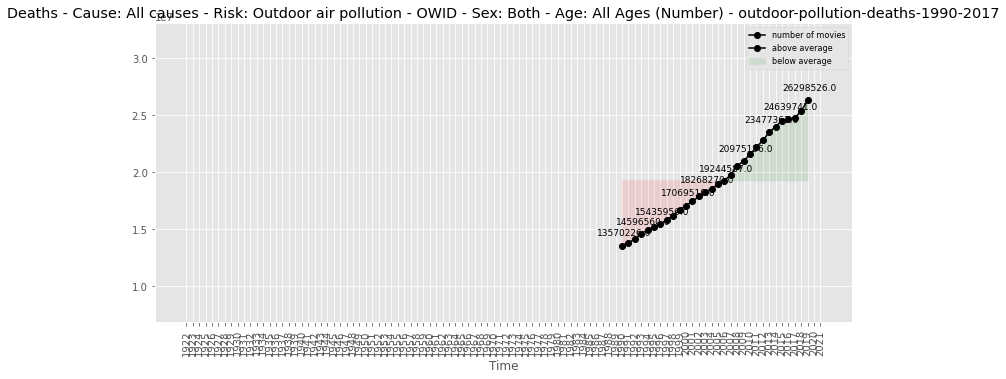

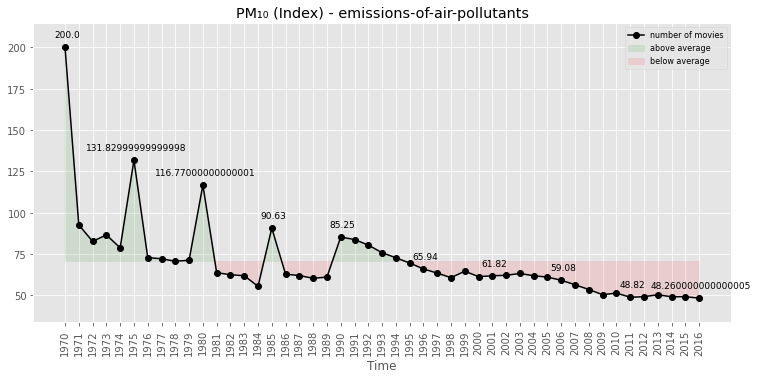

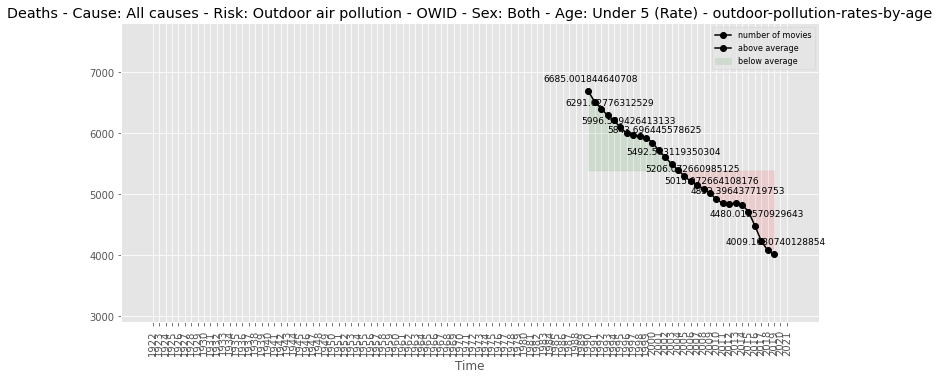

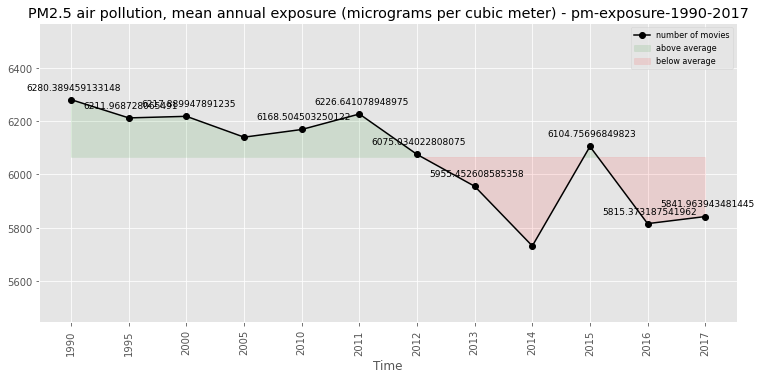

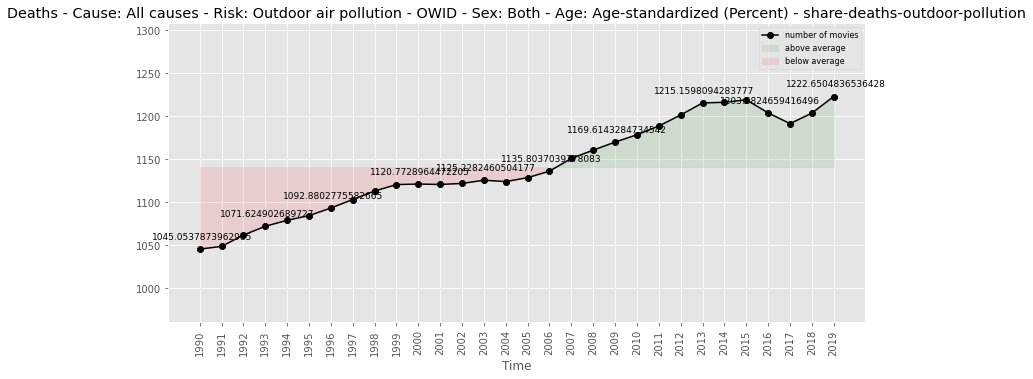

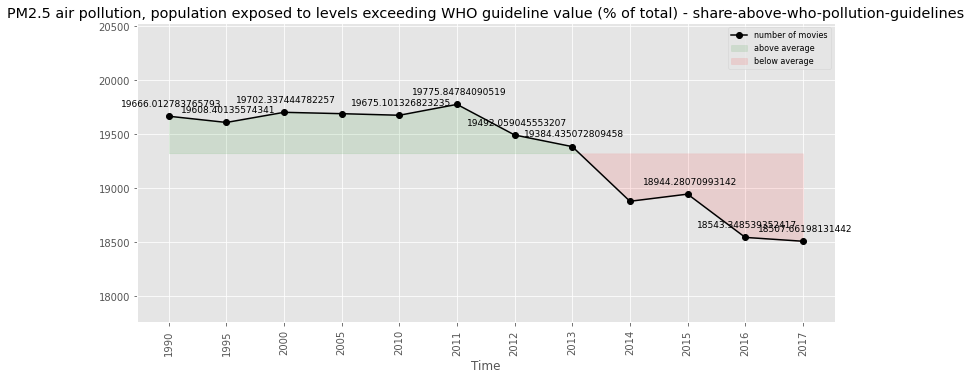

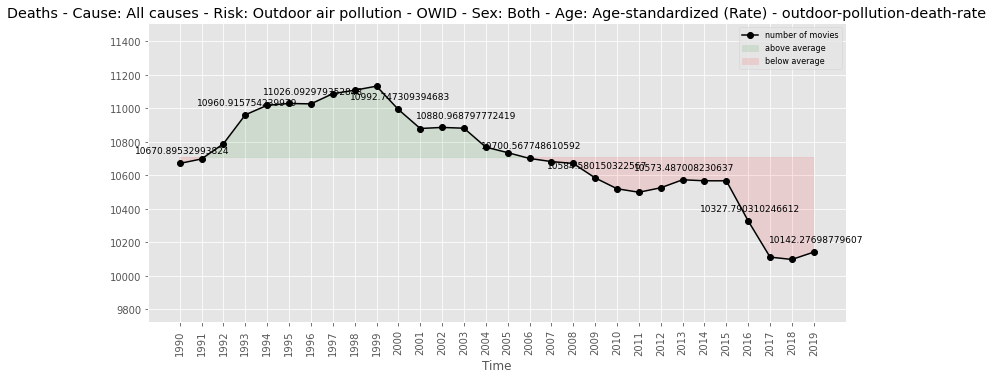

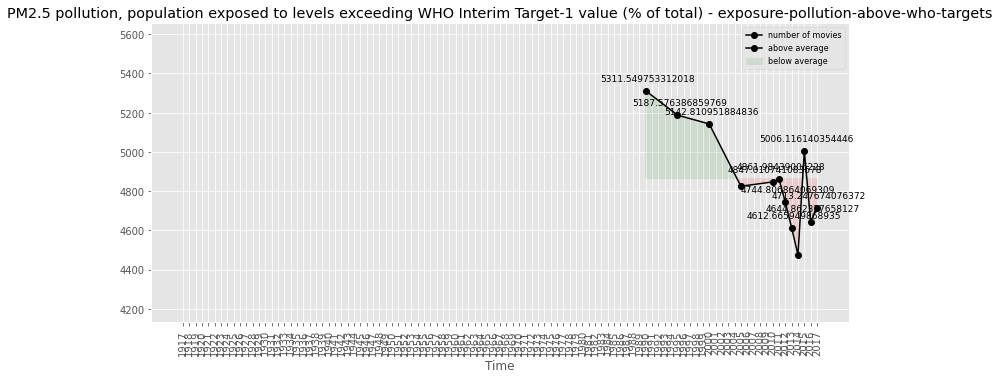

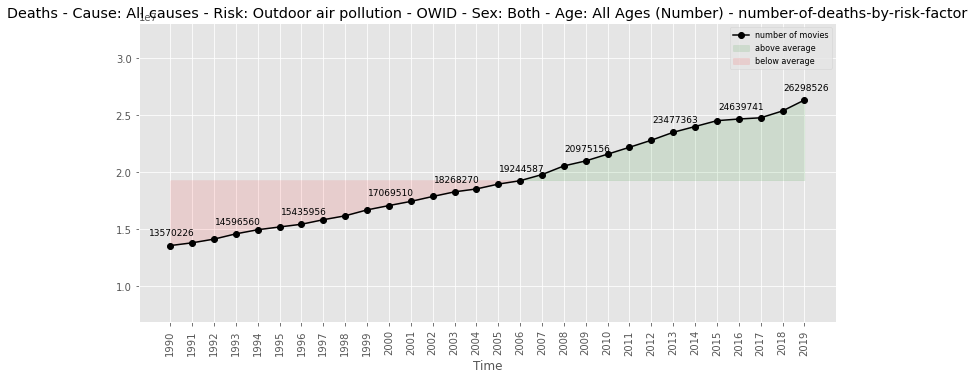

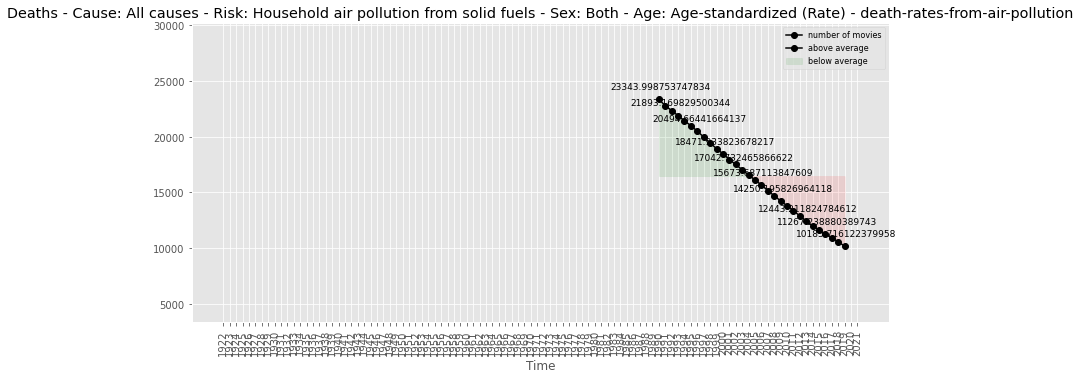

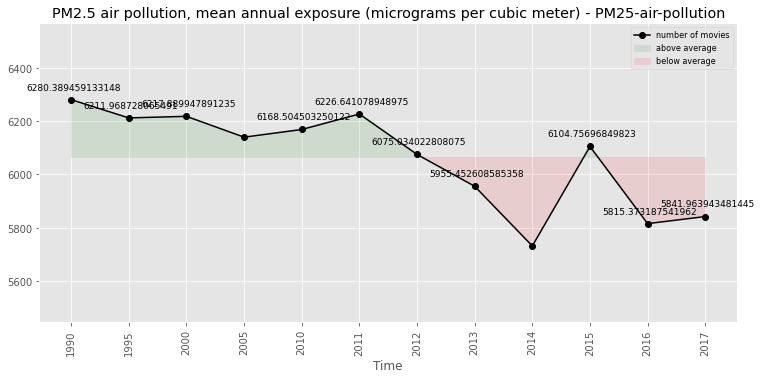

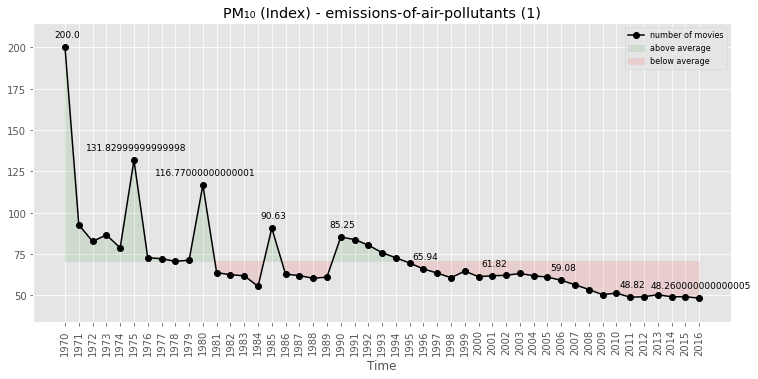

In [3]:
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
for df, target, date, title in zip(df_list, target_list, date_list, titles):
    try:
        y = aggregate_period(df, 'y', date, target)
        my_title = f"{target} - {title}"
        visual(y ,date,target,my_title,100,1,10, scientific_annotation=False)
    except:
        pass
 

# Plot Forecast Values using ARIMA <a class="anchor" id="0.4"></a>

All values are not exactly equal, not ideal for forcasting. Suggest to change to a broader period or treat the date first'
Calibrating best ARIMA
Optimised:  ARIMA(5,2,2)(0,0,0)[0]          


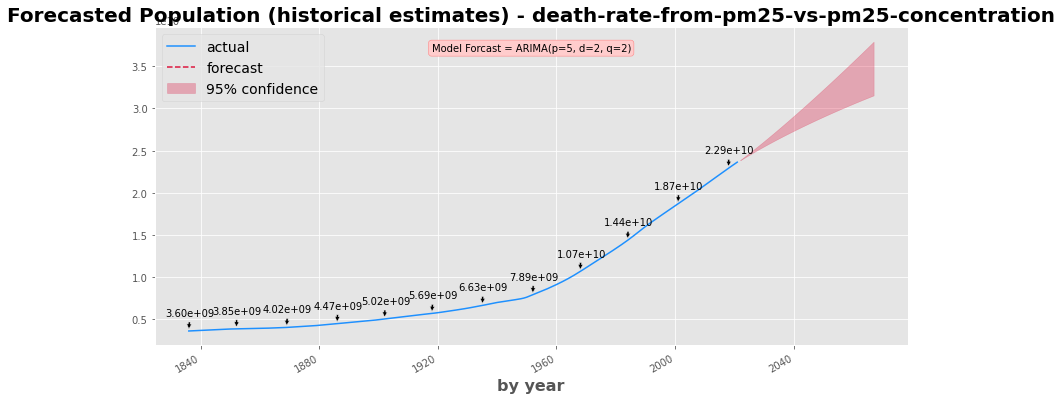

The date interval for each data points is the same, of 'year' interval
Calibrating best ARIMA
Optimised:  ARIMA(0,1,0)(0,0,0)[0] intercept


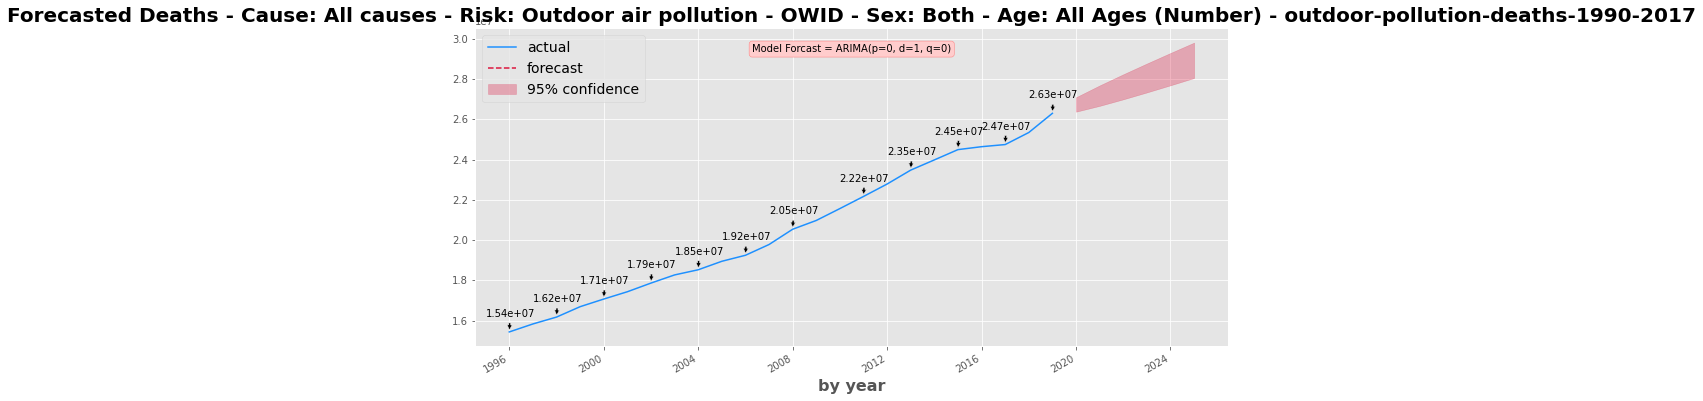

The date interval for each data points is the same, of 'year' interval
Calibrating best ARIMA
Optimised:  ARIMA(0,1,1)(0,0,0)[0] intercept


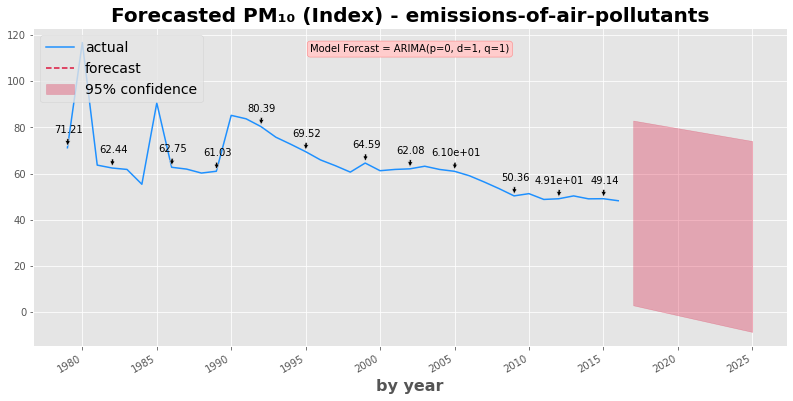

All values are not exactly equal, not ideal for forcasting. Suggest to change to a broader period or treat the date first'
Calibrating best ARIMA
Optimised:  ARIMA(5,2,2)(0,0,0)[0]          


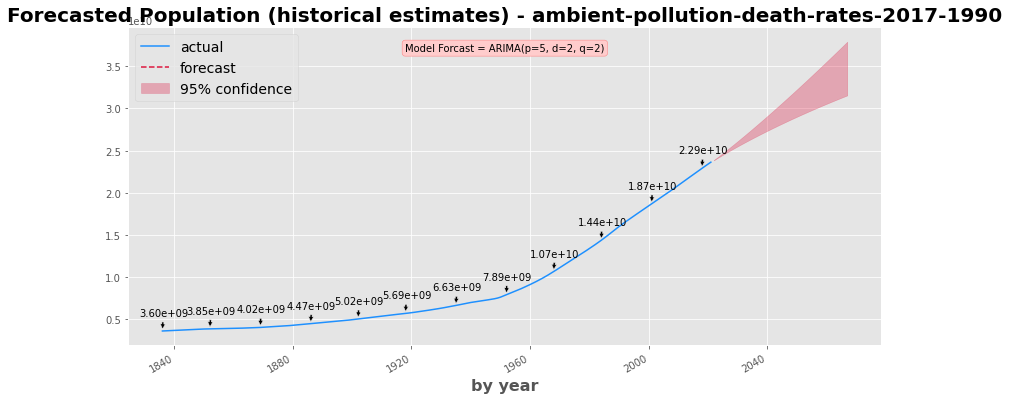

The date interval for each data points is the same, of 'year' interval
Calibrating best ARIMA
Optimised:  ARIMA(2,1,0)(0,0,0)[0] intercept


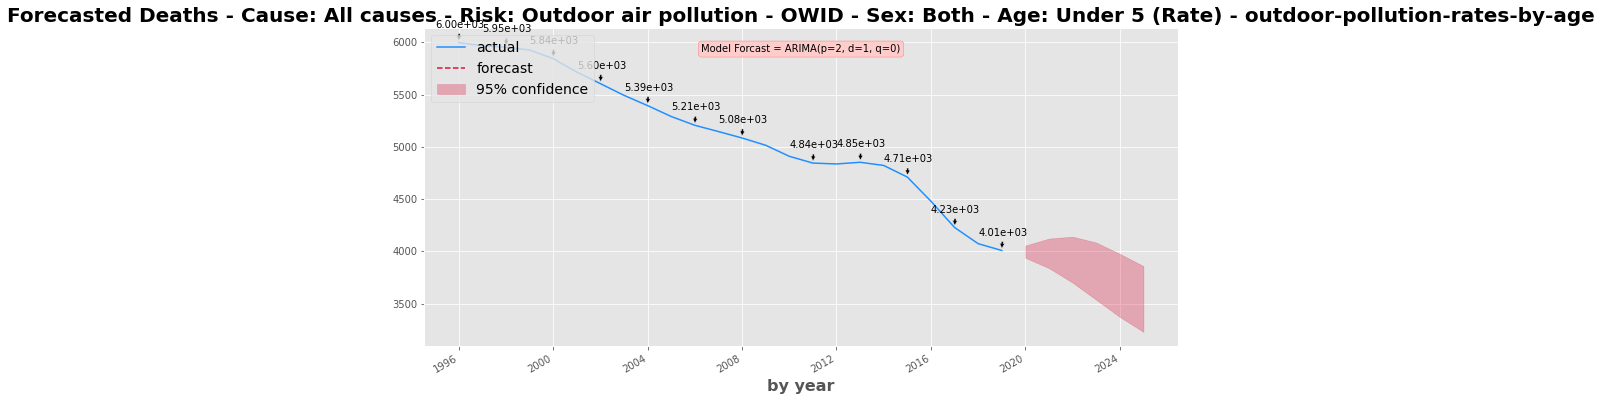

All values are not exactly equal, not ideal for forcasting. Suggest to change to a broader period or treat the date first'
Calibrating best ARIMA
Optimised:  ARIMA(1,1,0)(0,0,0)[0]          


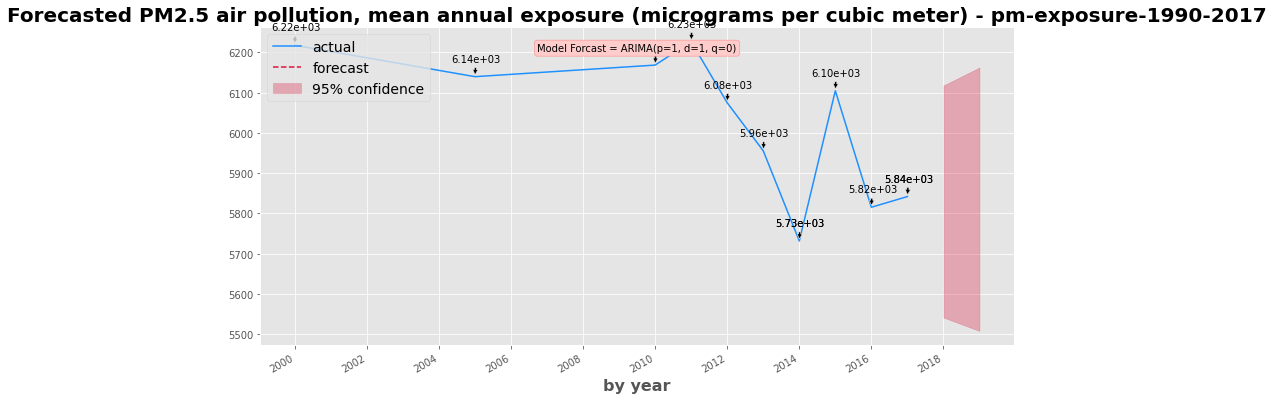

The date interval for each data points is the same, of 'year' interval
Calibrating best ARIMA
Optimised:  ARIMA(0,1,1)(0,0,0)[0] intercept


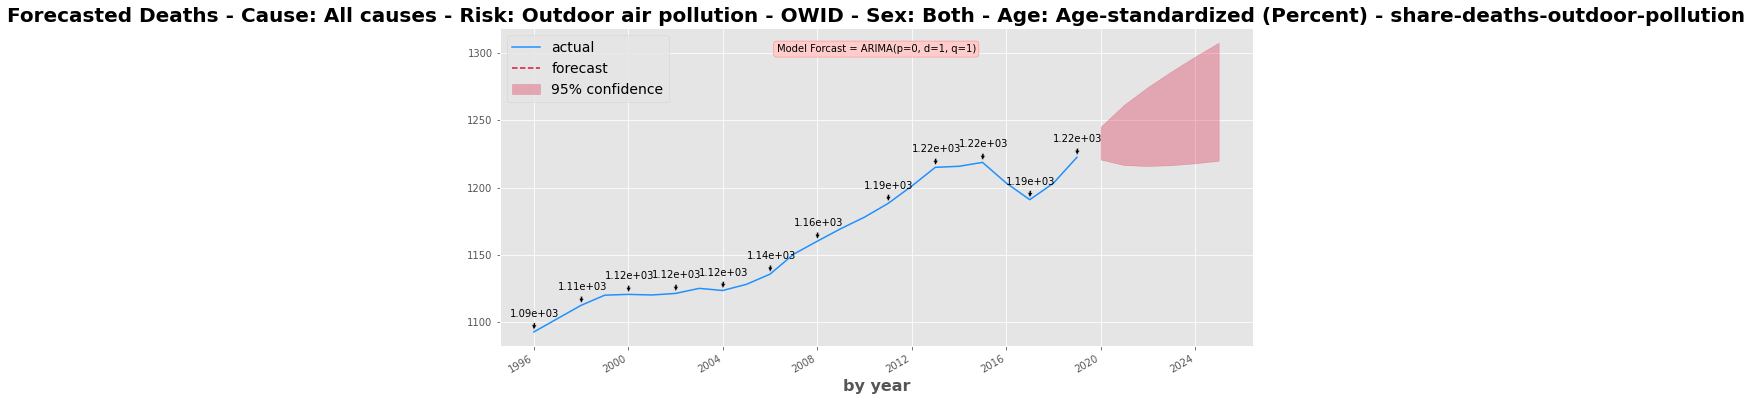

All values are not exactly equal, not ideal for forcasting. Suggest to change to a broader period or treat the date first'
Calibrating best ARIMA
Optimised:  ARIMA(0,0,1)(0,0,0)[0] intercept


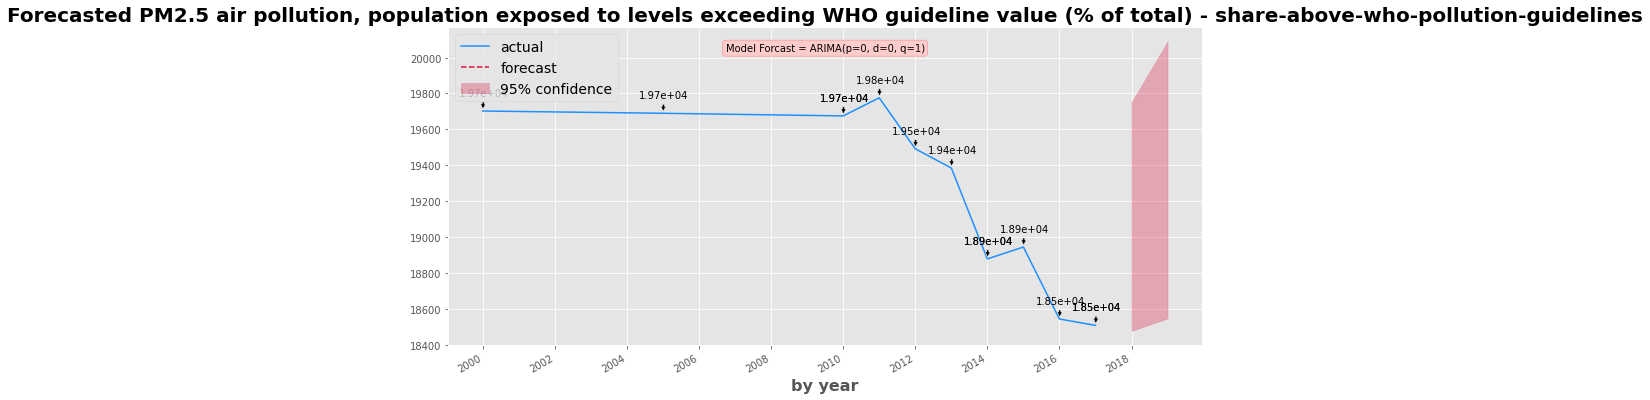

The date interval for each data points is the same, of 'year' interval
Calibrating best ARIMA
Optimised:  ARIMA(0,1,1)(0,0,0)[0]          


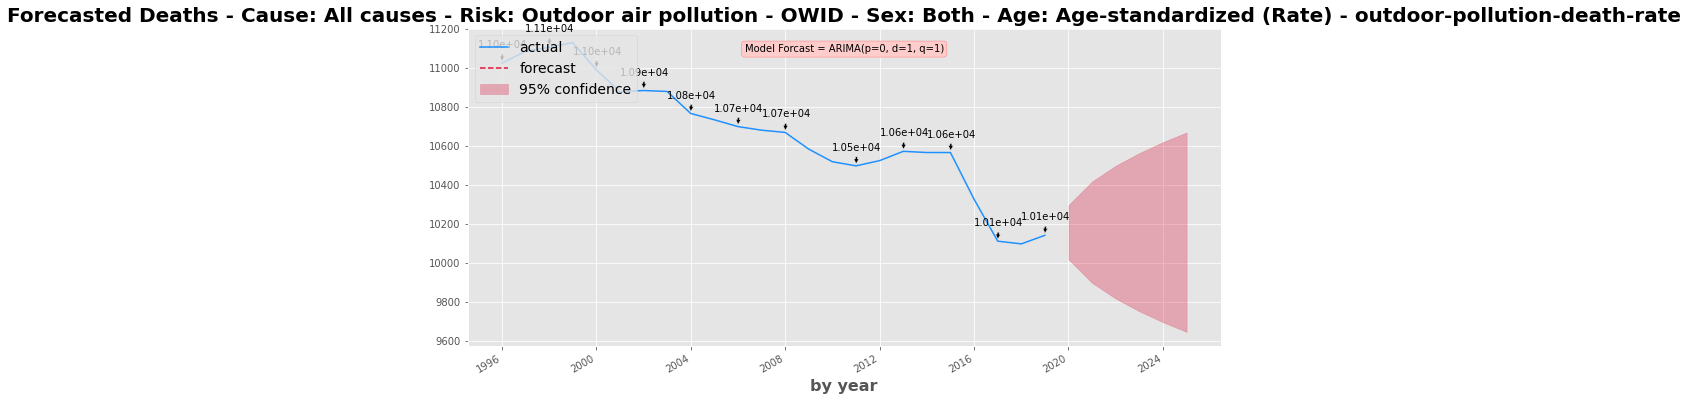

The date interval for each data points is the same, of 'year' interval
Calibrating best ARIMA
Optimised:  ARIMA(0,1,0)(0,0,0)[0]          


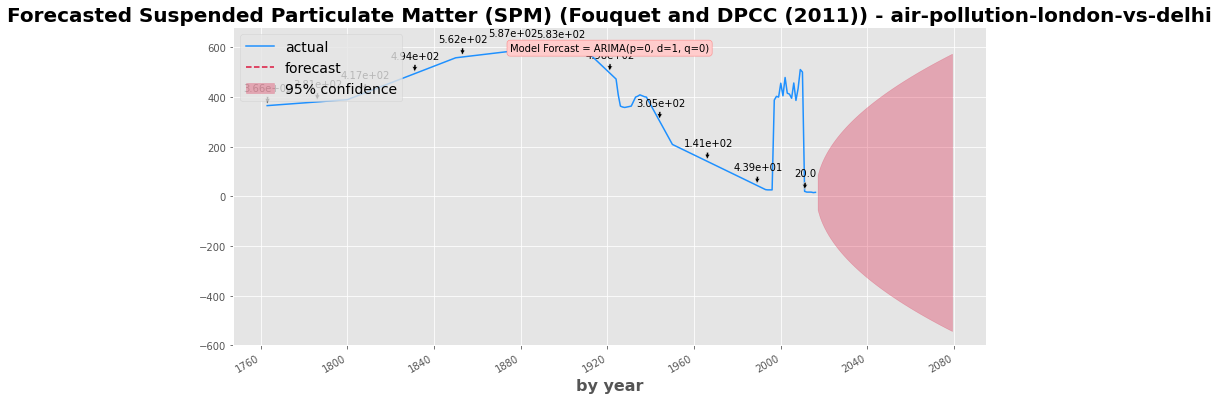

All values are not exactly equal, not ideal for forcasting. Suggest to change to a broader period or treat the date first'
Calibrating best ARIMA
Optimised:  ARIMA(1,0,0)(0,0,0)[0] intercept


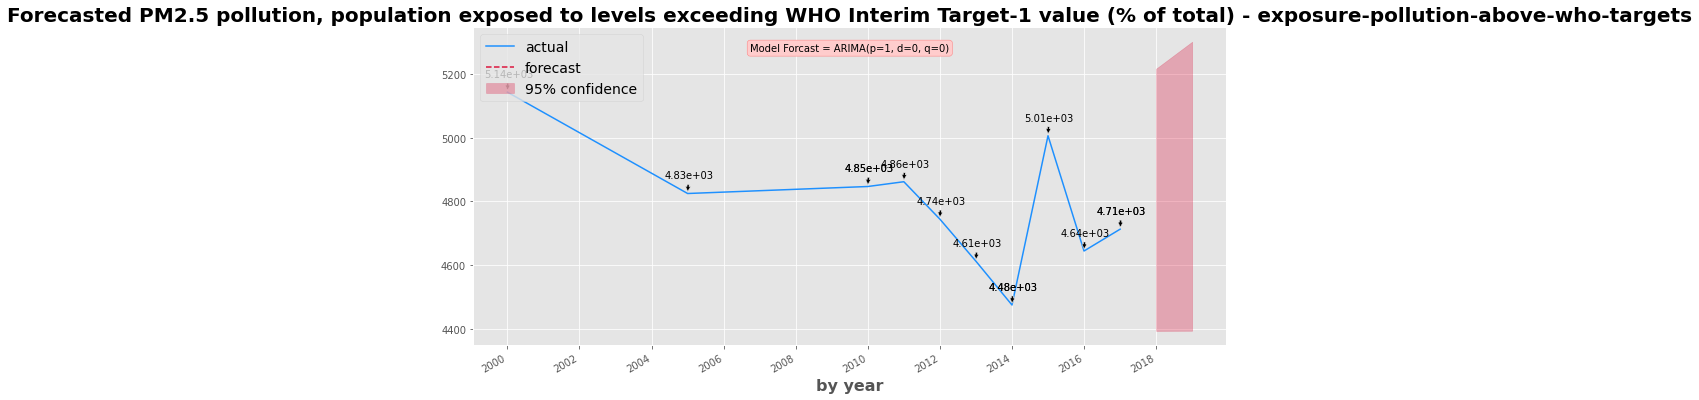

The date interval for each data points is the same, of 'year' interval
Calibrating best ARIMA
Optimised:  ARIMA(0,1,0)(0,0,0)[0] intercept


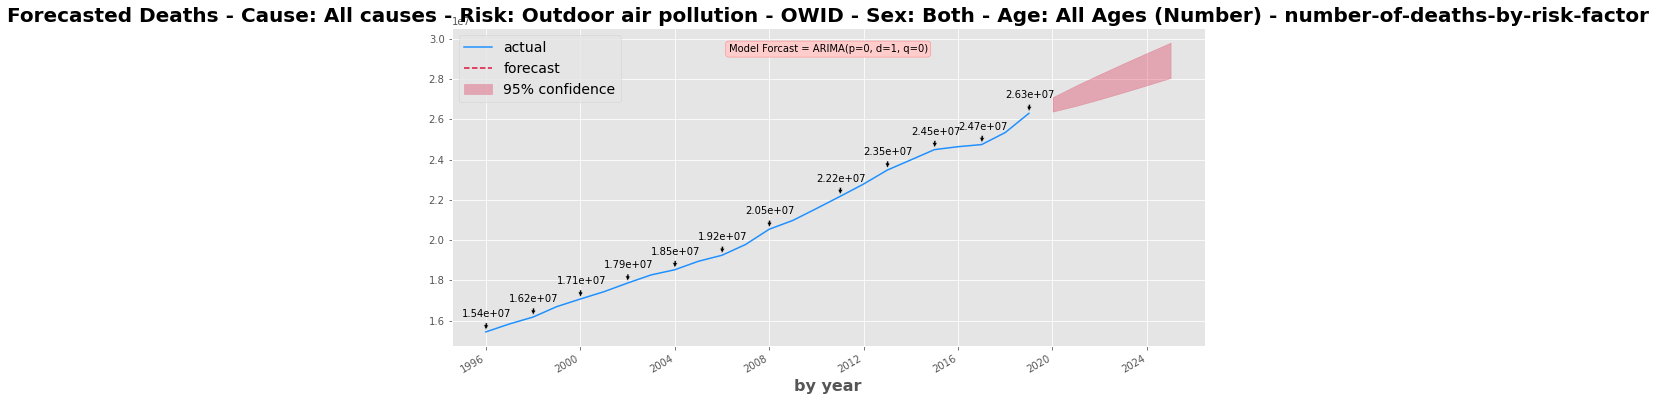

All values are not exactly equal, not ideal for forcasting. Suggest to change to a broader period or treat the date first'
Calibrating best ARIMA
Optimised:  ARIMA(5,2,2)(0,0,0)[0]          


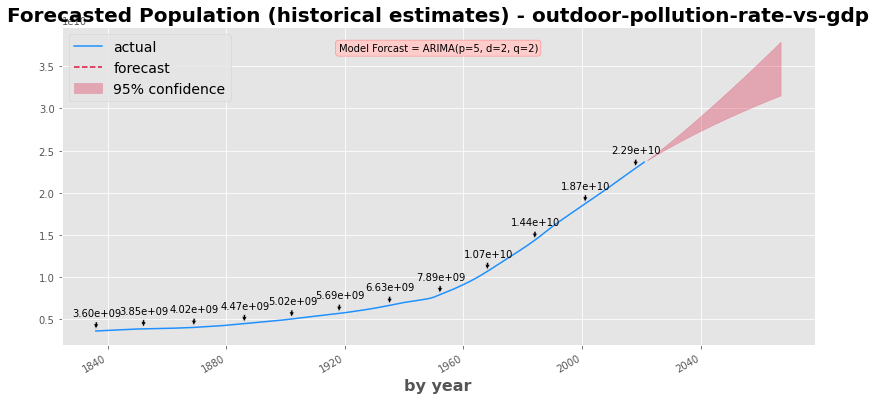

The date interval for each data points is the same, of 'year' interval
Calibrating best ARIMA
Optimised:  ARIMA(0,2,1)(0,0,0)[0]          


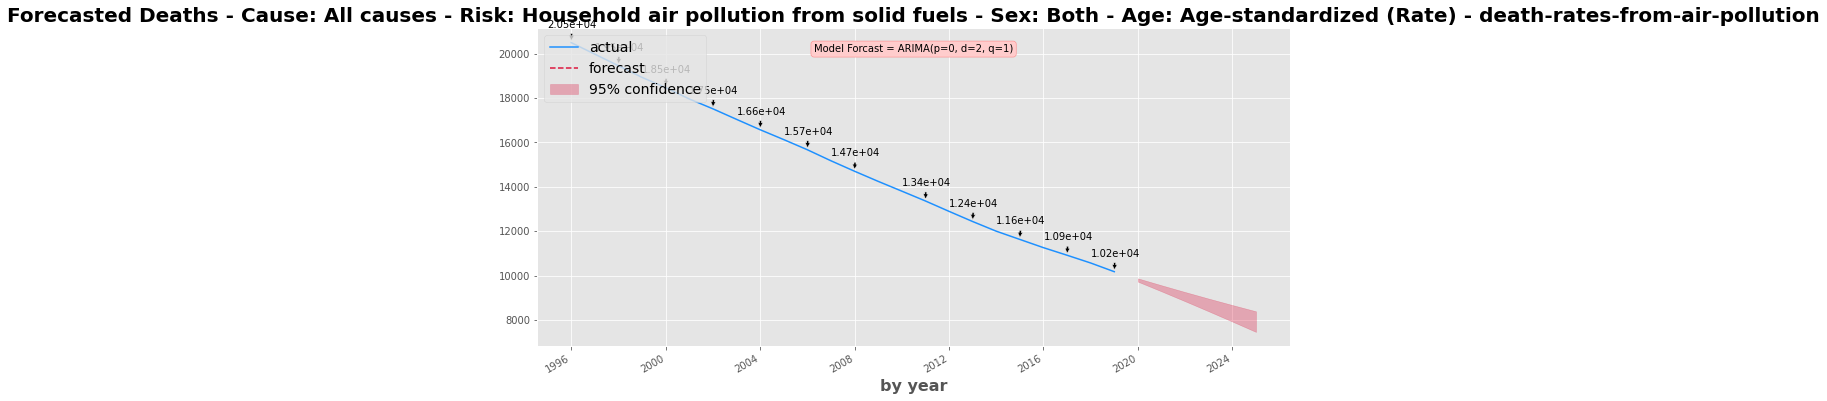

All values are not exactly equal, not ideal for forcasting. Suggest to change to a broader period or treat the date first'
Calibrating best ARIMA
Optimised:  ARIMA(1,1,0)(0,0,0)[0]          


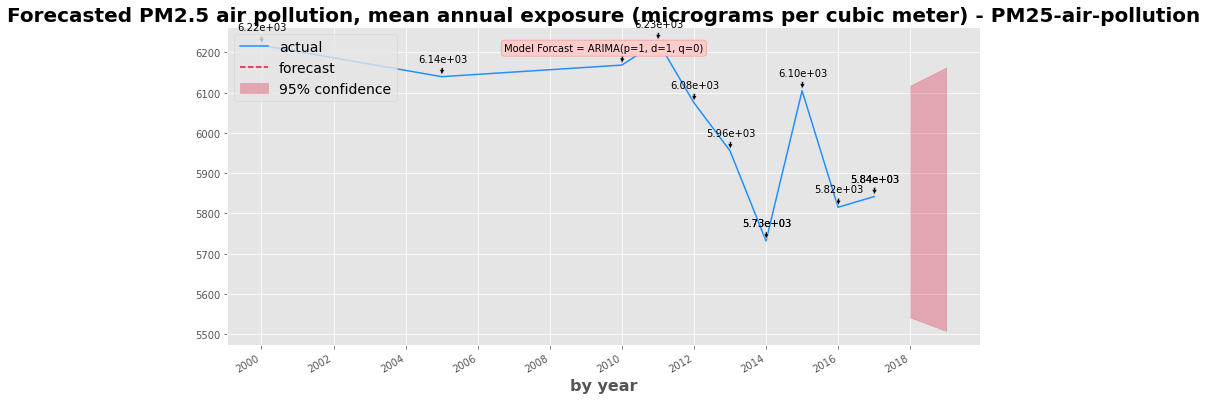

The date interval for each data points is the same, of 'year' interval
Calibrating best ARIMA
Optimised:  ARIMA(0,1,1)(0,0,0)[0] intercept


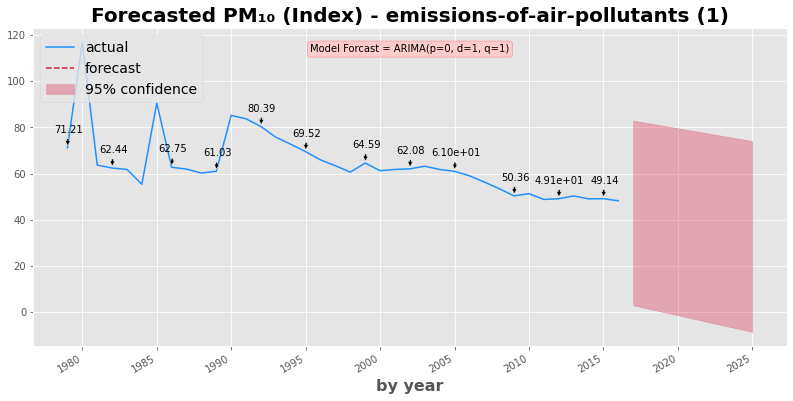

In [4]:
from forecast_tool import forecast_plot as fp
for df, target, date, title in zip(df_list, target_list, date_list, titles):
    try:
        fp.overall_vis(df, date, target, 'y', my_title =f"Forecasted {target} - {title}", matplotlib_style ='ggplot', y_label_name="", numElems=15)
    except:
        print(f"STAUS - An error occured for {title}")